# Get liquid display readings from video using OpenCV-Python
Written by Lei Lei</br>
Faculty of Engineering, University of Nottingham

1. Import packages

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'

2. The reading updates once per second. We only need to extract one frame per second from the video file. 

In [2]:
def rescaleFrame(frame, scale = 0.3):
    """Decrease the size of frames so that they are processed faster"""
    width = int(frame.shape[1]*scale)
    height = int(frame.shape[0]*scale)
    dimensions = (width, height)
    
    return cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)

In [3]:
# Reading Video
capture=cv2.VideoCapture('/mnt/c/users/stcik/scire/papers/muon/120C.MOV')
count = 0
success = True
fps = int(capture.get(cv2.CAP_PROP_FPS))
out_folder='/mnt/c/users/stcik/scire/papers/muon/120C/frames'
os.makedirs(out_folder,exist_ok=True)
while success:
    success, image = capture.read()
#     print('read a new frame:', success)
    if count%(1*fps) == 0 :
        image = rescaleFrame(image)
        cv2.imwrite(os.path.join(out_folder,'frame%d.jpg'%count),image)
#         print('Successfully written frame%d!'%count)
    count+=1

3. We need to crop the image to focus on the liquid crystal diplay area, this will save computational work.</br>
Define a crop function. Crop the image to save computation efforts and make the contour easier to be found.

In [2]:
def crop(img, params = (200, 400, 160, 300)):
    # Parameters in the order of y, h, x, w
    new_image = img[params[0]:params[1], params[2]:params[3]]
    return new_image

Then, we define a plot function to save a little bit of input work.

In [3]:
def plot(image, cmap=None):
    plt.axis('off')
    plt.imshow(image)

We can first use the first image in the frame directory to get an idea on what parameters we should use.

True

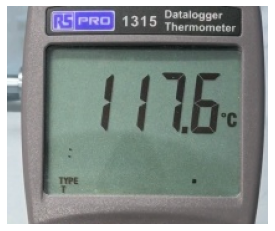

In [119]:
image_path=r'/mnt/c/users/stcik/scire/papers/muon/120C/frames/frame2320.jpg'
image=cv2.imread(image_path)
cropparams=(115,290,55,265)
new_image=crop(image, params=cropparams)
name = image_path.split('/')[-1]
plot(new_image)
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/cropped/{name}', new_image)

After we get proper parameters, we can batch crop the frames.

In [11]:
import re
rDir = r'/mnt/c/users/stcik/scire/papers/muon/120C/frames'
out_folder='/mnt/c/users/stcik/scire/papers/muon/120C/cropped'
os.makedirs(out_folder,exist_ok=True)
savs=[]
for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir, file))

for sav in savs:
    image_path=sav
    image=cv2.imread(image_path)
    new_image=crop(image, params=cropparams)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(out_folder, f'{name}'), new_image)

We need to have a look at the cropped images. For frames where camera moved a lot, we may need to mannually crop them.

In [25]:
nums = range(0,493,29)
for num in nums:
    num = str(num)
    image_path=f'/mnt/c/users/stcik/scire/papers/muon/120C/frames/frame{num}.jpg'
    image=cv2.imread(image_path)
    new_image = crop(image, params=(65,260,55,265))
#     plot(new_image)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join('/mnt/c/users/stcik/scire/papers/muon/120C/cropped/', f'{name}'), new_image)

In [133]:
nums = range(7192,7279,29)
for num in nums:
    num = str(num)
    image_path=f'/mnt/c/users/stcik/scire/papers/muon/120C/frames/frame{num}.jpg'
    image=cv2.imread(image_path)
    new_image = crop(image, params=(135,290,55,255))
#     plot(new_image)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join('/mnt/c/users/stcik/scire/papers/muon/120C/cropped/', f'{name}'), new_image)

4. We now need to make binary image from the cropped image.

In [28]:
def make_bin(img, gmin=160, gmax=255):
    """Make a binary image from the cropped image."""
    # Drop the color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Thresholding the image
    thresh, img_bin = cv2.threshold(img, gmin, gmax, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = ~img_bin
    return img_bin

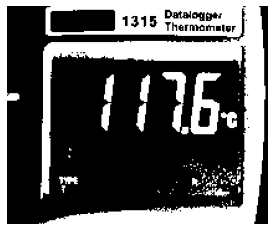

In [104]:
img_bin=make_bin(new_image)
plot(img_bin)

5. We now need to make final bin iamge for cv2 to find contours.</br>
Firstly, we define parameters to resolve vertical and horizontal lines.

In [105]:
line_min_width = 10
kernal_h = np.ones((3,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,3), np.uint8)

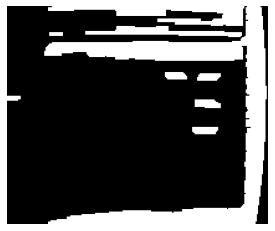

In [106]:
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
plot(img_bin_h)

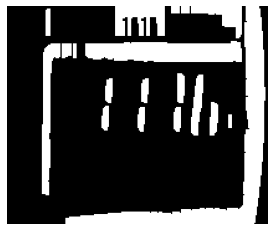

In [108]:
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
plot(img_bin_v)

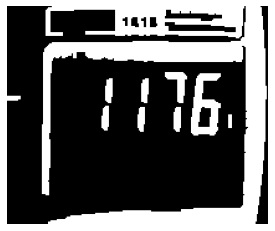

In [109]:
img_bin_final=img_bin_h|img_bin_v
plot(img_bin_final)

We can make the lines thicker so that the contours are easier to resolve.

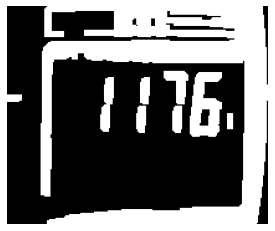

In [110]:
final_kernel = np.ones((3,3), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
plot(img_bin_final)

Now we can fin the contours and visualise the contours found.

In [111]:
#Retrieve contours 
contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#Create box-list
box = []
# Get position (x,y), width and height for every contour 
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    box.append([x,y,w,h])
print(box)

[[177, 86, 5, 13], [133, 80, 8, 22], [104, 80, 8, 22], [0, 71, 12, 6], [107, 57, 8, 22], [75, 57, 11, 44], [147, 53, 26, 52], [154, 82, 10, 15], [126, 52, 20, 27], [27, 0, 183, 175], [103, 14, 3, 3], [127, 13, 57, 8], [115, 9, 5, 8], [100, 9, 5, 7], [128, 3, 45, 9]]


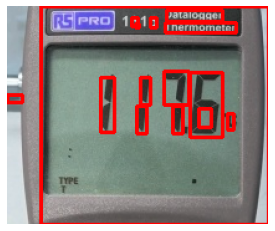

In [112]:
for n in box:
    img_box = new_image
    img_box = cv2.rectangle(img_box, (n[0], n[1]), (n[0]+n[2], n[1]+n[3]), (255,0,0), 2)
plt.axis('off')
plt.imshow(img_box)

6. We can now set up parameters to sort the contours found so that we keep our readings only.

Firstly, lets sort our contours, so that the boxes are well ordered.

In [121]:
# We will use the size and position of the contourbox to filter the boxes.
def get_reading(img, contours):
    # Get the width and height of the image
    height, width,_ = img.shape
    print(width, height)
    textcont=[]
    for c in contours:
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # We will only use the height of the numbers, because all numbers have about the same height but 1 is much narrower than other numbers.
        # We will only use the y positions, because the x positions has a larger distribution.
        if 0.5 > h/height > 0.1 and y/(height-y-h) > 0.4:
            textcont.append(c)
            print(x, y, w, h, h/height, y/(height-y-h))
    return textcont

In [113]:
textcont = get_reading(new_image, contours)

210 175
133 80 8 22 0.12571428571428572 1.095890410958904
104 80 8 22 0.12571428571428572 1.095890410958904
107 57 8 22 0.12571428571428572 0.59375
75 57 11 44 0.25142857142857145 0.7702702702702703
147 53 26 52 0.29714285714285715 0.7571428571428571
126 52 20 27 0.15428571428571428 0.5416666666666666


In [114]:
textbox = []
for c in textcont:
    x, y, w, h = cv2.boundingRect(c)
    textbox.append([x,y,w,h])
print(textbox)

[[133, 80, 8, 22], [104, 80, 8, 22], [107, 57, 8, 22], [75, 57, 11, 44], [147, 53, 26, 52], [126, 52, 20, 27]]


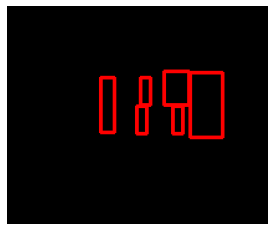

In [115]:
img_box = np.zeros(new_image.shape, dtype = "uint8")
for n in textbox:
    img_box = cv2.rectangle(img_box, (n[0],n[1]), (n[0]+n[2],n[1]+n[3]), (255,0,0), 2)
plot(img_box)

7. Now we can crop the image according to the textboxes. 

In [7]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [117]:
textcont, textboxes = sort_contours(textcont, method="left-to-right")
print(textboxes)

((75, 57, 11, 44), (104, 80, 8, 22), (107, 57, 8, 22), (126, 52, 20, 27), (133, 80, 8, 22), (147, 53, 26, 52))


52 102 75 173


True

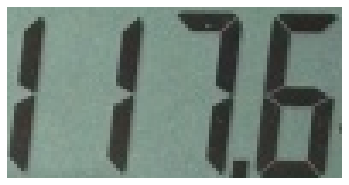

In [120]:
textcont, textboxes = sort_contours(textcont, method="left-to-right")
xpos, xwidth = textboxes[0][0], textboxes[-1][0]+textboxes[-1][2]
textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
ypos, yheight=textboxes[0][1], textboxes[-1][1]+textboxes[-1][3]
print(ypos, yheight, xpos, xwidth)
new_image = new_image[ypos:yheight, xpos:xwidth]
plot(new_image)
# !mkdir /mnt/c/users/stcik/scire/papers/muon/120C/outs
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/outs/{name}', new_image)

8. To batch process the cropped frames, we need to make functions.

In [76]:
def make_bin(img, gmin=160, gmax=255):
    """Make a binary image from the cropped image."""
    # Drop the color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Thresholding the image
    thresh, img_bin = cv2.threshold(img, gmin, gmax, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = ~img_bin
    cv2.imwrite("Images/Image_bin.jpg", img_bin)
    return img_bin

def get_lines(img, line_min_width = 10, kernal_h = np.ones((3,line_min_width), np.uint8), kernal_v = np.ones((line_min_width,3), np.uint8)):
    # Detect vertical lines from an image
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    # Detect horizontal lines
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
      
    img_bin_final=img_bin_h|img_bin_v
    
    final_kernel = np.ones((3, 3), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    return img_bin_final

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def get_reading(img, img_path, contours, folder):
        # Get the width and height of the image
    height, width,_ = img.shape
    textcont=[]
    for c in contours:
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c)
#         print(h/height, y/(height-y-h))
        # We will only use the height of the numbers, because all numbers have about the same height but 1 is much narrower than other numbers.
        # We will only use the y positions, because the x positions has a larger distribution.
        if 0.4 > h/height > 0.11 and y > 0.25*(height-y-h):
            textcont.append(c)
    textcont, textboxes = sort_contours(textcont, method="left-to-right")
    xpos, xwidth = textboxes[0][0], textboxes[-1][0]+textboxes[-1][2]
    textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
    ypos, yheight=textboxes[0][1], textboxes[0][1]+textboxes[0][3]
    new_img = img[ypos:yheight, xpos:xwidth]
    name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(folder, f'{name}'), new_img)

9. Finally, we can use the above defined functions to batch process the frames and save the detected region into ./outs directory.

In [77]:
savs=[]
rDir = r'/mnt/c/users/stcik/scire/papers/muon/120C/cropped'
out_folder=r'/mnt/c/users/stcik/scire/papers/muon/120C/outs'
os.makedirs(out_folder,exist_ok=True)

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir, file))
for sav in savs:
    image=cv2.imread(sav)
    img_bin = make_bin(image)
    img_bin = get_lines(img_bin)
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    get_reading(image, img_path=sav, contours = contours, folder = out_folder)

10. Now go to the ./outs directory, check the outputs. Change parameters and try again.</br>
I have 250 frames, only 4 of them are not correctly detect. The success rate is 98.4 %.

In [249]:
rDir = '/mnt/c/users/stcik/scire/papers/muon/80C/cropped/'
out_folder='/mnt/c/users/stcik/scire/papers/muon/80C/outs'
os.makedirs(out_folder,exist_ok=True)
names=('80C_frame4350.jpg.jpg', '80C_frame6438.jpg.jpg', '80C_frame6670.jpg.jpg', '80C_frame6873.jpg.jpg')
for name in names:
    image_path=rDir+name
    image=cv2.imread(image_path)
    img_bin = make_bin(image)
    img_bin = get_lines(img_bin,  line_min_width = 8, kernal_h = np.ones((4,line_min_width), np.uint8), kernal_v = np.ones((line_min_width,4), np.uint8))
    # Find contours for image, which will detect all the boxes
    contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    get_reading(image, img_path=image_path, contours = contours, folder = out_folder)

11. If you have problem with certain images, you can go back to the manual mode and see what happened.</br>
I have problem with the following file, which turned out to be the reading in this image is not clear. The number '3' is broken which makes the contour box split into two small one and filtered by the conditions I set in the get_reading function. If we set the lower height bound smaller, it will work.

In [57]:
def make_bin(img, gmin=190, gmax=255):
    """Make a binary image from the cropped image."""
    # Drop the color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Thresholding the image
    thresh, img_bin = cv2.threshold(img, gmin, gmax, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # Invert the image
    img_bin = ~img_bin
    return img_bin

In [43]:
# We will use the size and position of the contourbox to filter the boxes.
def get_reading(img, contours):
    # Get the width and height of the image
    height, width,_ = img.shape
    print(width, height)
    textcont=[]
    for c in contours:
        # Returns the location and width, height for every contour
        x, y, w, h = cv2.boundingRect(c)
        # We will only use the height of the numbers, because all numbers have about the same height but 1 is much narrower than other numbers.
        # We will only use the y positions, because the x positions has a larger distribution.
        if 0.5 > h/height > 0.1 and y > 0.3*(height-y-h):
            textcont.append(c)
            print(x, y, w, h, h/height, y/(height-y-h))
    return textcont

In [6]:
line_min_width = 9
kernal_h = np.ones((3,line_min_width), np.uint8)
kernal_v = np.ones((line_min_width,3), np.uint8)

True

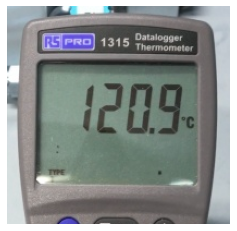

In [50]:
image_path=r'/mnt/c/users/stcik/scire/papers/muon/120C/frames/frame7192.jpg'
image=cv2.imread(image_path)
cropparams=(130,330,65,270)
new_image=crop(image, params=cropparams)
name = image_path.split('/')[-1]
plot(new_image)
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/cropped/{name}', new_image)

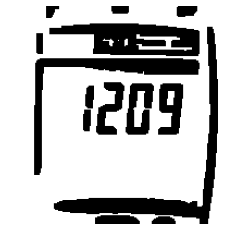

In [41]:
img_bin=make_bin(new_image)
img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
img_bin_final=img_bin_h|img_bin_v
final_kernel = np.ones((3,3), np.uint8)
img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
img_bin_final=~img_bin_final
plot(img_bin_final)

205 200
69 94 9 22 0.11 1.119047619047619
71 72 10 23 0.115 0.6857142857142857
138 70 25 49 0.245 0.8641975308641975
108 70 28 49 0.245 0.8641975308641975
81 69 28 50 0.25 0.8518518518518519
[[69, 94, 9, 22], [71, 72, 10, 23], [138, 70, 25, 49], [108, 70, 28, 49], [81, 69, 28, 50]]


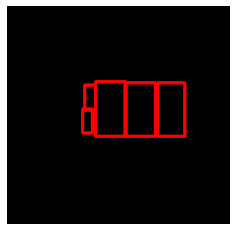

In [45]:
#Retrieve contours 
contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
textcont = get_reading(new_image, contours)
textbox = []
for c in textcont:
    x, y, w, h = cv2.boundingRect(c)
    textbox.append([x,y,w,h])
print(textbox)
for n in textbox:
    img_box = cv2.rectangle(img_box, (n[0],n[1]), (n[0]+n[2],n[1]+n[3]), (255,0,0), 2)
plot(img_box)

71 119 66 163


True

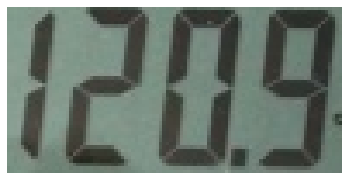

In [51]:
textcont, textboxes = sort_contours(textcont, method="left-to-right")
xpos, xwidth = textboxes[0][0]-3, textboxes[-1][0]+textboxes[-1][2]
textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
ypos, yheight = textboxes[0][1]+2, textboxes[1][1]+textboxes[1][3]
print(ypos, yheight, xpos, xwidth)
new_image = new_image[ypos:yheight, xpos:xwidth]
plot(new_image)
cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/outs/{name}', new_image)

In [11]:
nums = range(4669,5220,29)
for num in nums:
    num = str(num)
    image_path=f'/mnt/c/users/stcik/scire/papers/muon/120C/frames/frame{num}.jpg'
    cropparams=(100,290,65,275)
    image=cv2.imread(image_path)
    new_image=crop(image, params=cropparams)
    name = image_path.split('/')[-1]
    cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/cropped/{name}', new_image)
    img_bin=make_bin(new_image)
    img_bin_h = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_h)
    img_bin_v = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, kernal_v)
    img_bin_final=img_bin_h|img_bin_v
    final_kernel = np.ones((3,3), np.uint8)
    img_bin_final=cv2.dilate(img_bin_final,final_kernel,iterations=1)
    #Retrieve contours 
    contours, hierarchy = cv2.findContours(img_bin_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    textcont = get_reading(new_image, contours)
    textcont, textboxes = sort_contours(textcont, method="left-to-right")
    xpos, xwidth = textboxes[0][0]-8, textboxes[-1][0]+textboxes[-1][2]
    textcont, textboxes = sort_contours(textcont, method="top-to-bottom")
    ypos, yheight=textboxes[0][1], textboxes[-1][1]+textboxes[-1][3]+3
    print(ypos, yheight, xpos, xwidth)
    new_image = new_image[ypos:yheight, xpos:xwidth]

    cv2.imwrite(f'/mnt/c/users/stcik/scire/papers/muon/120C/outs/{name}', new_image)

210 190
69 78 8 24 0.12631578947368421 0.8863636363636364
146 54 26 49 0.2578947368421053 0.6206896551724138
71 54 9 23 0.12105263157894737 0.4778761061946903
113 51 29 54 0.28421052631578947 0.6
82 51 29 54 0.28421052631578947 0.6
51 105 61 172
210 190
65 78 9 24 0.12631578947368421 0.8863636363636364
68 54 9 23 0.12105263157894737 0.4778761061946903
150 50 21 53 0.2789473684210526 0.5747126436781609
110 50 29 55 0.2894736842105263 0.5882352941176471
117 58 16 40 0.21052631578947367 0.6304347826086957
79 50 29 55 0.2894736842105263 0.5882352941176471
50 105 57 171
210 190
115 80 26 27 0.14210526315789473 0.963855421686747
71 56 11 48 0.25263157894736843 0.6511627906976745
155 53 21 53 0.2789473684210526 0.6309523809523809
119 53 26 27 0.14210526315789473 0.4818181818181818
84 52 30 55 0.2894736842105263 0.6265060240963856
52 110 63 176
210 190
67 77 8 24 0.12631578947368421 0.8651685393258427
70 53 8 23 0.12105263157894737 0.4649122807017544
151 49 21 53 0.2789473684210526 0.556818181

12. It is useful to make the detected readings binary so that it is easier to be recognised by OCR packages. 

In [58]:
rDir = r'/mnt/c/users/stcik/scire/papers/muon/120C/outs'
out_folder='/mnt/c/users/stcik/scire/papers/muon/120C/binary'
os.makedirs(out_folder, exist_ok=True)
savs=[]

for file in os.listdir(rDir):
    if file.endswith(".jpg"):
        savs.append(os.path.join(rDir,file))

for sav in savs:
    image_path=sav
    image=cv2.imread(sav)
    img_bin=make_bin(image, gmin=130, gmax=255)
    name = image_path.split('/')[-1]
    cv2.imwrite(os.path.join(out_folder, f'{name}'), img_bin)